In [1]:
!pip install pyspark



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("OnlineRetailAnalysis") \
    .getOrCreate()


In [3]:
file_path = "OnlineRetail.csv"
df = spark.read.option("header", "true").csv(file_path)


In [4]:
df.printSchema()
df.show(5)


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|    

In [6]:
from pyspark.sql.functions import col

# Drop rows with null values in essential columns
df_cleaned = df.dropna(subset=["CustomerID", "InvoiceNo", "Quantity", "UnitPrice"])

# Convert data types
df_cleaned = df_cleaned.withColumn("Quantity", col("Quantity").cast("integer"))
df_cleaned = df_cleaned.withColumn("UnitPrice", col("UnitPrice").cast("float"))

# Add Total Amount Column
df_cleaned = df_cleaned.withColumn("TotalAmount", col("Quantity") * col("UnitPrice"))


In [10]:
#Goal 1: Aggregate total sales by product category.
from pyspark.sql.functions import sum, desc

total_sales_by_product = df_cleaned.groupBy("Description") \
                                   .agg(sum("TotalAmount").alias("TotalSales")) \
                                   .orderBy(desc("TotalSales"))
total_sales_by_product.show()



+--------------------+------------------+
|         Description|        TotalSales|
+--------------------+------------------+
|REGENCY CAKESTAND...|132870.39842033386|
|WHITE HANGING HEA...| 93823.85021972656|
|JUMBO BAG RED RET...| 83236.75914800167|
|       PARTY BUNTING| 67687.52895641327|
|             POSTAGE| 66710.23997282982|
|ASSORTED COLOUR B...| 56499.22161626816|
|  RABBIT NIGHT LIGHT| 51137.79873275757|
|       CHILLI LIGHTS| 45936.80920600891|
|PAPER CHAIN KIT 5...| 41500.48054909706|
|PICNIC BASKET WIC...|           39619.5|
|BLACK RECORD COVE...|39009.380932569504|
|JUMBO BAG PINK PO...| 36473.00962162018|
|      SPOTTY BUNTING| 35056.43924474716|
|DOORMAT KEEP CALM...| 34312.60008621216|
|WOOD BLACK BOARD ...| 34307.06030130386|
|SET OF 3 CAKE TIN...|32607.799204826355|
|JAM MAKING SET WI...|31658.470012664795|
|JUMBO BAG STRAWBERRY| 30195.70976638794|
|HEART OF WICKER L...|28331.450761795044|
|VICTORIAN GLASS H...|28152.859741687775|
+--------------------+------------

In [11]:
#Customer Segmentation by Total Spending.
from pyspark.sql.functions import when

customer_segments = df_cleaned.groupBy("CustomerID") \
                              .agg(sum("TotalAmount").alias("TotalSpent")) \
                              .withColumn("Segment",
                                          when(col("TotalSpent") >= 1000, "High Value")
                                          .when((col("TotalSpent") < 1000) & (col("TotalSpent") >= 500), "Medium Value")
                                          .otherwise("Low Value"))
customer_segments.show()


+----------+------------------+------------+
|CustomerID|        TotalSpent|     Segment|
+----------+------------------+------------+
|     16250| 389.4399948120117|   Low Value|
|     15574| 702.2499952316284|Medium Value|
|     15555| 4758.199949376285|  High Value|
|     15271| 2485.819998562336|  High Value|
|     17757| 5585.489989101887|  High Value|
|     17551| 306.8399999141693|   Low Value|
|     13187|236.01999950408936|   Low Value|
|     16549| 4154.639983385801|  High Value|
|     14525| 4221.369975358248|  High Value|
|     18283|2094.8799839913845|  High Value|
|     13174|2817.0299954414368|  High Value|
|     13027|            6912.0|  High Value|
|     12957| 3979.040013194084|  High Value|
|     17128|157.09000182151794|   Low Value|
|     14810| 2087.879978656769|  High Value|
|     16654| 594.9700038433075|Medium Value|
|     17491| 3541.919949531555|  High Value|
|     17917|341.27999997138977|   Low Value|
|     14639|2952.3400053977966|  High Value|
|     1737

In [14]:
#Monthly Sales Trends.
from pyspark.sql.functions import month, year

monthly_sales_trend = df_cleaned.withColumn("Month", month("InvoiceDate")) \
                                .withColumn("Year", year("InvoiceDate")) \
                                .groupBy("Year", "Month") \
                                .agg(sum("TotalAmount").alias("MonthlySales")) \
                                .orderBy("Year", "Month")
monthly_sales_trend.show()


+----+-----+-----------------+
|Year|Month|     MonthlySales|
+----+-----+-----------------+
|NULL| NULL|8300065.789371256|
+----+-----+-----------------+



In [15]:
#Top 10 Customers by Total Spending
from pyspark.sql.functions import sum, desc

top_customers = df_cleaned.groupBy("CustomerID") \
                          .agg(sum("TotalAmount").alias("TotalSpent")) \
                          .orderBy(desc("TotalSpent")) \
                          .limit(10)

top_customers.show()


+----------+------------------+
|CustomerID|        TotalSpent|
+----------+------------------+
|     14646|279489.01930066943|
|     18102|256438.48995232582|
|     17450| 187482.1704902649|
|     14911|132572.61962211132|
|     12415|123725.44990730286|
|     14156|113384.13939154148|
|     17511| 88125.37999302149|
|     16684| 65892.07912826538|
|     13694| 62653.09981799126|
|     15311| 59419.33947509527|
+----------+------------------+



In [16]:
# Analyze Product Returns (Negative Quantities)
returns = df_cleaned.filter(col("Quantity") < 0) \
                    .groupBy("Description") \
                    .agg(sum("Quantity").alias("TotalReturns")) \
                    .orderBy("TotalReturns")

returns.show(10)


+--------------------+------------+
|         Description|TotalReturns|
+--------------------+------------+
|PAPER CRAFT , LIT...|      -80995|
|MEDIUM CERAMIC TO...|      -74494|
|ROTATING SILVER A...|       -9367|
|              Manual|       -3995|
|FAIRY CAKE FLANNE...|       -3150|
|PINK BLUE FELT CR...|       -2617|
|WHITE HANGING HEA...|       -2578|
|GIN + TONIC DIET ...|       -2030|
|   HERB MARKER BASIL|       -1527|
|FELTCRAFT DOLL MOLLY|       -1447|
+--------------------+------------+
only showing top 10 rows



In [19]:
total_sales_pd = total_sales_by_product.toPandas()
monthly_sales_trend_pd = monthly_sales_trend.toPandas()
#Convert Spark DataFrames to Pandas DataFrames for plotting.

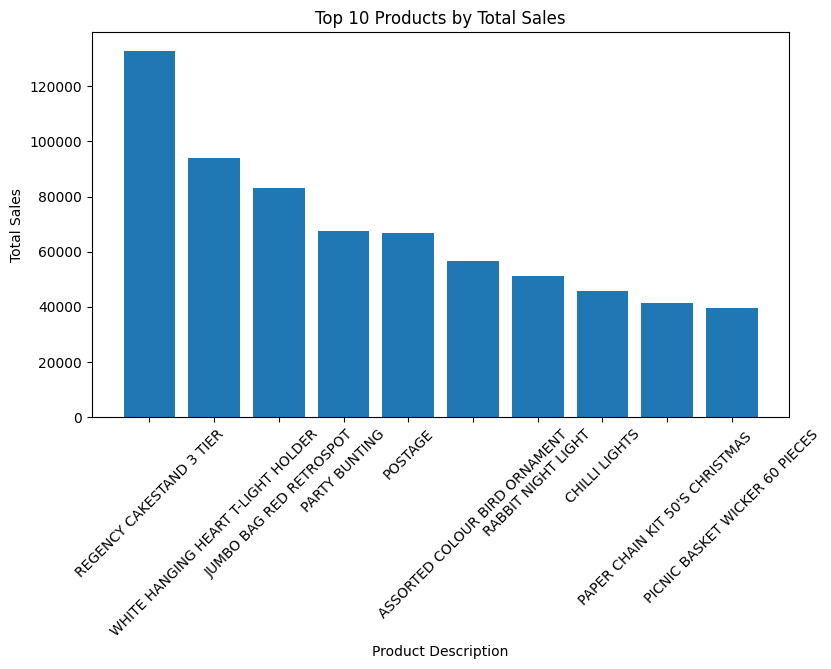

In [21]:
#Plot Total Sales by Product:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))
plt.bar(total_sales_pd["Description"][:10], total_sales_pd["TotalSales"][:10])
plt.title("Top 10 Products by Total Sales")
plt.xlabel("Product Description")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

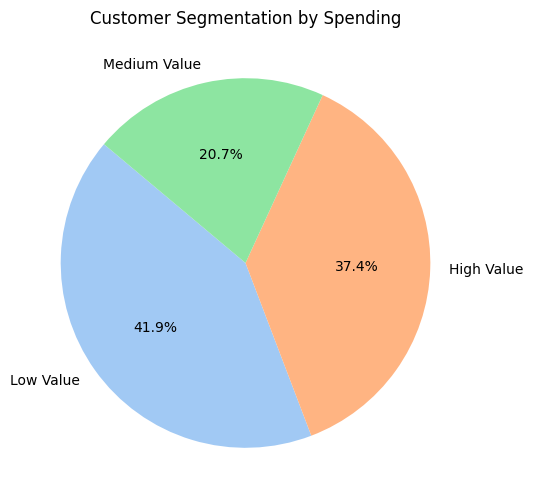

In [26]:
#Customer Segmentation by Total Spending
# Convert Spark DataFrame to Pandas for visualization
customer_segments_pd = customer_segments.toPandas()

# Count the number of customers in each segment
segment_counts = customer_segments_pd["Segment"].value_counts()

# Plot
plt.figure(figsize=(8, 6))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Customer Segmentation by Spending")
plt.show()



C:\Users\S567067\AppData\Local\Temp\ipykernel_26004\774226893.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=returns_pd, x="TotalReturns", y="Description", palette="coolwarm")


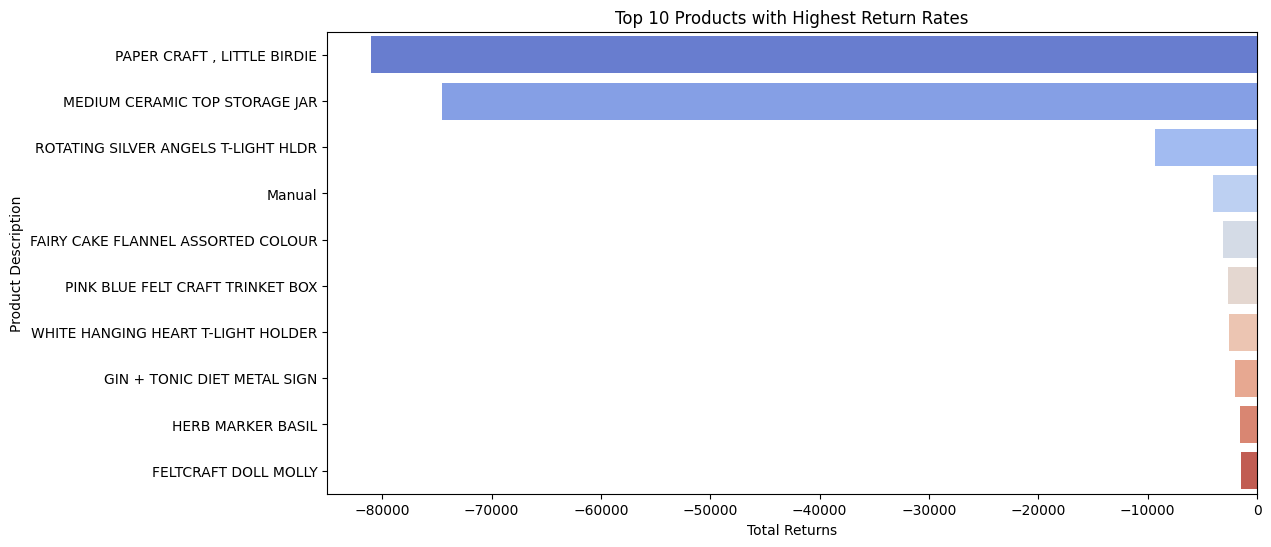

In [31]:
#Top 10 Products with Highest Return Rates
# Convert Spark DataFrame to Pandas for visualization
returns_pd = returns.limit(10).toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=returns_pd, x="TotalReturns", y="Description", palette="coolwarm")
plt.title("Top 10 Products with Highest Return Rates")
plt.xlabel("Total Returns")
plt.ylabel("Product Description")
plt.show()
